---
title: "CHRONIC KIDNEY DISEASE PREDICTION USING BOOSTING ALGORITHMS"
author: "Asabere Kwabena Asante"
df-print: kable
code-overflow: wrap
execute: 
  echo: true
  warning: false
  message: false
format: html
editor: visual
editor_options: 
  chunk_output_type: console
---

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [19]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve,auc


In [4]:
## load the chronic kidney disease dataset
kidneydx = pd.read_csv(r"C:\Users\KAsab\Desktop\PORTFOLIO PROJECTS\Chronic_Kidney_Dsease_data.csv")

In [5]:
kidneydx.head()

,PatientID,Age,Gender,Ethnicity,SocioeconomicStatus,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,...,Itching,QualityOfLifeScore,HeavyMetalsExposure,OccupationalExposureChemicals,WaterQuality,MedicalCheckupsFrequency,MedicationAdherence,HealthLiteracy,Diagnosis,DoctorInCharge
0,1,71,0,0,0,2,31.069414,1,5.128112,1.676220,...,7.556302,76.076800,0,0,1,1.018824,4.966808,9.871449,1,Confidential
1,2,34,0,0,1,3,29.692119,1,18.609552,8.377574,...,6.836766,40.128498,0,0,0,3.923538,8.189275,7.161765,1,Confidential
2,3,80,1,1,0,1,37.394822,1,11.882429,9.607401,...,2.144722,92.872842,0,1,1,1.429906,7.624028,7.354632,1,Confidential
3,4,40,0,2,0,1,31.329680,0,16.020165,0.408871,...,7.077188,90.080321,0,0,0,3.226416,3.282688,6.629587,1,Confidential
4,5,43,0,1,1,2,23.726311,0,7.944146,0.780319,...,3.553118,5.258372,0,0,1,0.285466,3.849498,1.437385,1,Confidential


In [6]:
kidneydx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1659 entries, 0 to 1658
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   PatientID                      1659 non-null   int64  
 1   Age                            1659 non-null   int64  
 2   Gender                         1659 non-null   int64  
 3   Ethnicity                      1659 non-null   int64  
 4   SocioeconomicStatus            1659 non-null   int64  
 5   EducationLevel                 1659 non-null   int64  
 6   BMI                            1659 non-null   float64
 7   Smoking                        1659 non-null   int64  
 8   AlcoholConsumption             1659 non-null   float64
 9   PhysicalActivity               1659 non-null   float64
 10  DietQuality                    1659 non-null   float64
 11  SleepQuality                   1659 non-null   float64
 12  FamilyHistoryKidneyDisease     1659 non-null   i

### **Preprocessing**

In [7]:
kidneydx.shape

(1659, 54)

In [8]:
## check for missing values
kidneydx.isnull().sum()

PatientID                        0
Age                              0
Gender                           0
Ethnicity                        0
SocioeconomicStatus              0
EducationLevel                   0
BMI                              0
Smoking                          0
AlcoholConsumption               0
PhysicalActivity                 0
DietQuality                      0
SleepQuality                     0
FamilyHistoryKidneyDisease       0
FamilyHistoryHypertension        0
FamilyHistoryDiabetes            0
PreviousAcuteKidneyInjury        0
UrinaryTractInfections           0
SystolicBP                       0
DiastolicBP                      0
FastingBloodSugar                0
HbA1c                            0
SerumCreatinine                  0
BUNLevels                        0
GFR                              0
ProteinInUrine                   0
ACR                              0
SerumElectrolytesSodium          0
SerumElectrolytesPotassium       0
SerumElectrolytesCal

In [9]:
kidneydx['Diagnosis'].value_counts()

Diagnosis
1    1524
0     135
Name: count, dtype: int64

In [10]:
## divide dataset into features and target variables
X = kidneydx.iloc[:,1:-2]
y = kidneydx.iloc[:,-2]



In [11]:
## split the features unto training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#### *Preprocessing Pipeline*

In [12]:
# Numeric pipeline
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore',sparse_output=False))
])

# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline,make_column_selector(dtype_include=np.number)),
    ('cat', categorical_pipeline,make_column_selector(dtype_include=object))
])

# Fit and transform training data, transform test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

### **Model Building**

In [13]:
## Build a dictionary of models and hyperparameters 
## XGBoost,AdaBoost and Histogram Gradient Boosting

models = {
    "XGBoost": (
        Pipeline([
            ('preprocess', preprocessor),
            ('clf', XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42))
        ]),
        {
            'clf__n_estimators': [100, 200],
            'clf__max_depth': [3, 5, 7]
        }
    ),
    "AdaBoost": (
        Pipeline([
            ('preprocess', preprocessor),
            ('clf', AdaBoostClassifier(random_state=42))
        ]),
        {
            'clf__n_estimators': [50, 100],
            'clf__learning_rate': [0.5, 1.0, 1.5]
        }
    ),
    "HistGradientBoosting": (
        Pipeline([
            ('preprocess', preprocessor),
            ('clf', HistGradientBoostingClassifier(random_state=42))
        ]),
        {
            'clf__learning_rate': [0.05, 0.1],
            'clf__max_iter': [100, 200],
            'clf__max_depth': [3, 5, None]
        }
    )
}


In [14]:
## train models and select best model from each gradient boosting algorithm
from sklearn.model_selection import GridSearchCV

best_models = {}

for name, (pipeline, params) in models.items():
    grid = GridSearchCV(pipeline, param_grid=params, scoring='roc_auc', cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"{name} Best AUC: {grid.best_score_:.3f}")


c:\Users\KAsab\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:34:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Best AUC: 0.851


c:\Users\KAsab\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Best AUC: 0.791
HistGradientBoosting Best AUC: 0.853


### ***Precision-Recall Curve, ROC-AUC Curve***

In [21]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

In [15]:
## extract the predicted probabilities of each model
y_scores_ada = best_models["AdaBoost"].predict_proba(X_test)[:, 1]
y_scores_hist = best_models["HistGradientBoosting"].predict_proba(X_test)[:, 1]
y_scores_xgb = best_models["XGBoost"].predict_proba(X_test)[:, 1]  


In [16]:

## create a function to plot ROC-AUC Curves and precision Recall Curves
# Compute ROC and PR metrics
def plot_model_curves(y_test, y_scores_dict):
    plt.figure(figsize=(12, 5))

    # ROC Curve
    plt.subplot(1, 2, 1)
    for name, y_scores in y_scores_dict.items():
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)

    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    for name, y_scores in y_scores_dict.items():
        precision, recall, _ = precision_recall_curve(y_test, y_scores)
        ap = average_precision_score(y_test, y_scores)
        plt.plot(recall, precision, label=f"{name} (AP = {ap:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



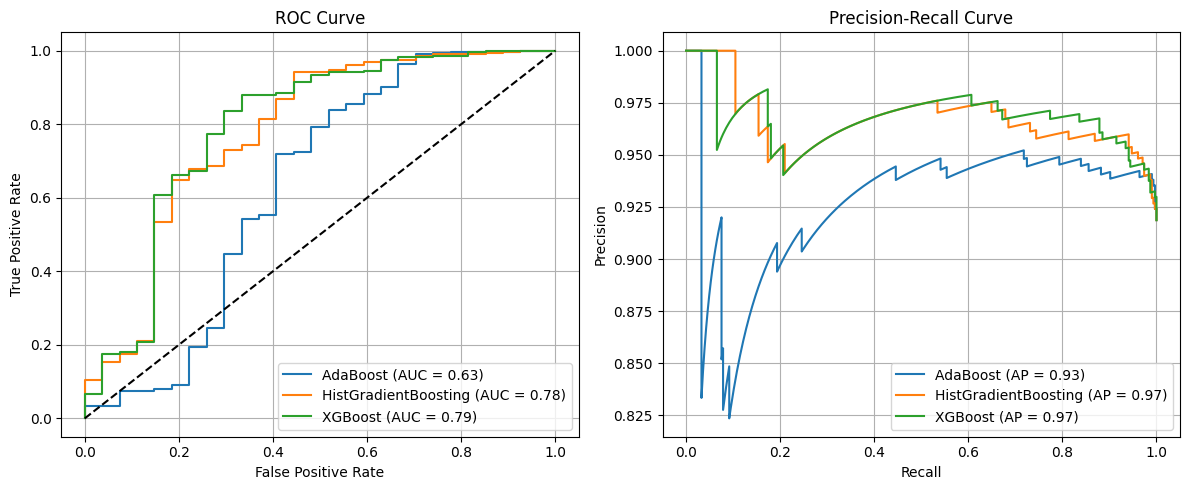

In [22]:
y_scores_dict = {
    "AdaBoost": y_scores_ada,
    "HistGradientBoosting": y_scores_hist,
    "XGBoost": y_scores_xgb  # only include if trained
}

plot_model_curves(y_test, y_scores_dict)

### ***Confusion Matrices***

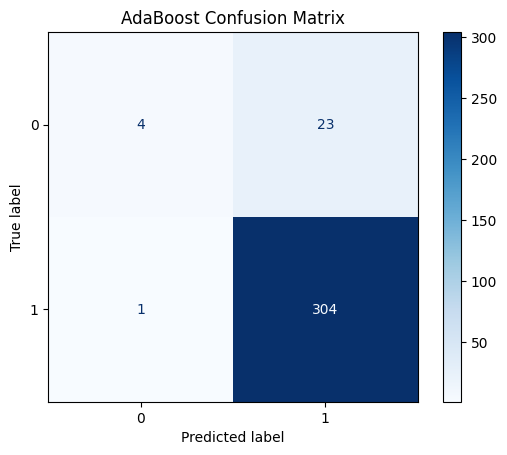

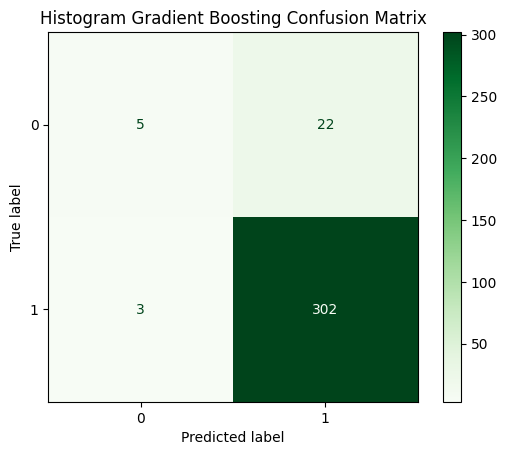

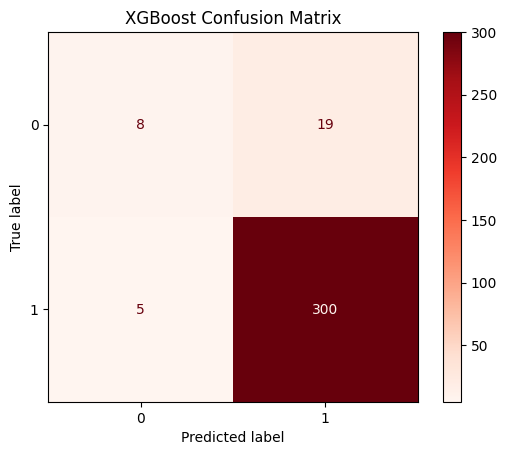

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(best_models["AdaBoost"], X_test, y_test, cmap='Blues')
plt.title("AdaBoost Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_estimator(best_models["HistGradientBoosting"], X_test, y_test, cmap='Greens')
plt.title("Histogram Gradient Boosting Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_estimator(best_models["XGBoost"], X_test, y_test, cmap='Reds')
plt.title("XGBoost Confusion Matrix")
plt.show()


#### ***Feature Importance for `XGBoost` Model***

In [ ]:
# Get trained pipeline and steps
xgb_pipeline = best_models["XGBoost"]
xgb_model = xgb_pipeline.named_steps['clf']  # XGBClassifier
preprocessor = xgb_pipeline.named_steps['preprocess']  # ColumnTransformer

# Get feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Extract feature importances
importances = xgb_model.feature_importances_


In [ ]:

# Build DataFrame of features and importance
xgb_feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).head(15)  # Top 15


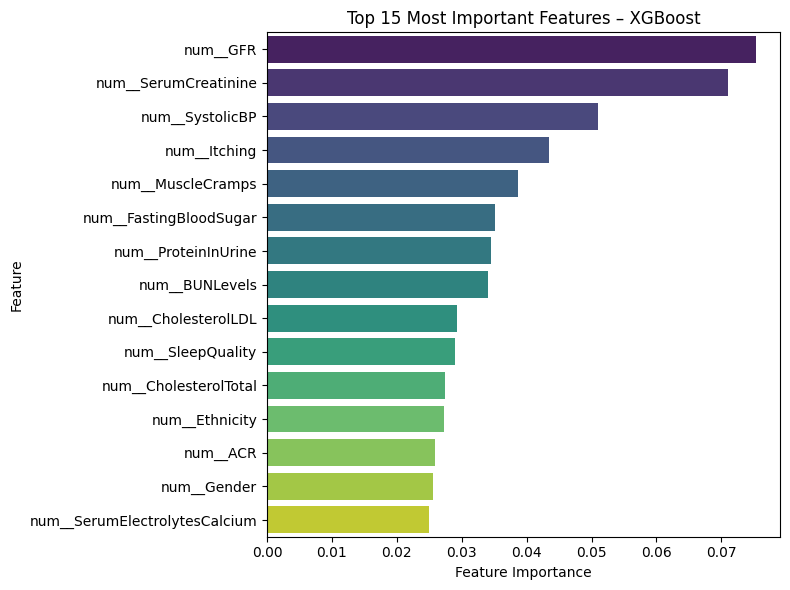

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(data=xgb_feat_imp, x="Importance", y="Feature",hue="Feature", palette="viridis")
plt.title("Top 15 Most Important Features – XGBoost")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


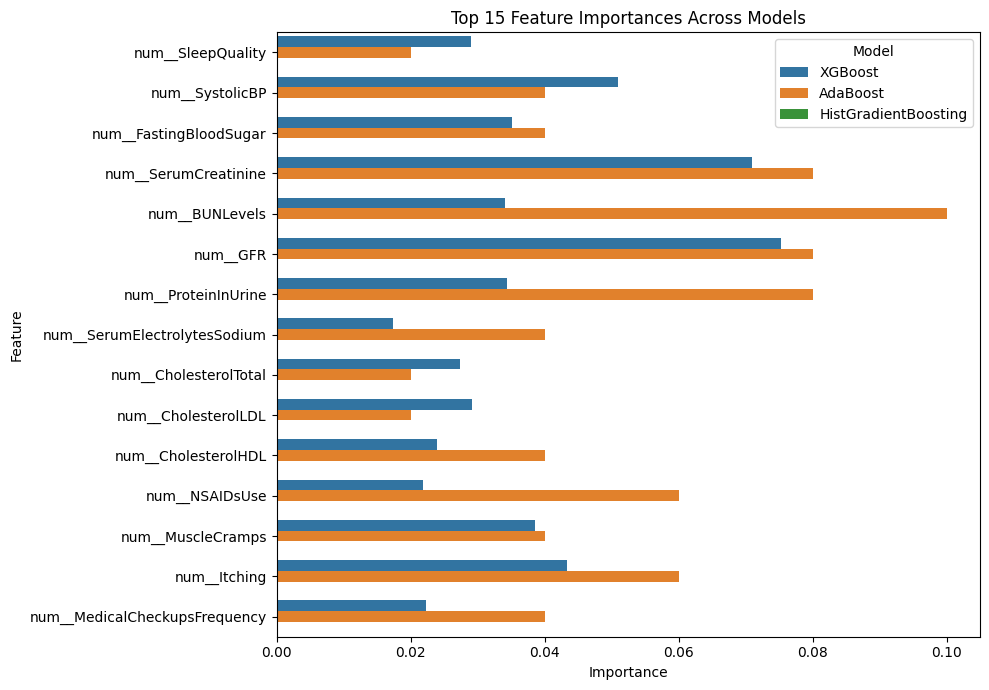

In [ ]:
# Extract feature names
feature_names = preprocessor.get_feature_names_out()

# Extract feature importances
xgb_imp = best_models["XGBoost"].named_steps['clf'].feature_importances_
ada_imp = best_models["AdaBoost"].named_steps['clf'].feature_importances_

# HistGradientBoosting uses same API in recent sklearn
hist_model = best_models["HistGradientBoosting"].named_steps['clf']
hist_imp = hist_model.feature_importances_ if hasattr(hist_model, "feature_importances_") else [0] * len(feature_names)

# Build individual dataframes
xgb_df = pd.DataFrame({'Feature': feature_names, 'Importance': xgb_imp, 'Model': 'XGBoost'})
ada_df = pd.DataFrame({'Feature': feature_names, 'Importance': ada_imp, 'Model': 'AdaBoost'})
hist_df = pd.DataFrame({'Feature': feature_names, 'Importance': hist_imp, 'Model': 'HistGradientBoosting'})

# Combine all
imp_df = pd.concat([xgb_df, ada_df, hist_df])

# Get top 15 overall features
top_feats = imp_df.groupby('Feature')['Importance'].sum().sort_values(ascending=False).head(15).index
imp_df_top15 = imp_df[imp_df['Feature'].isin(top_feats)]

plt.figure(figsize=(10, 7))
sns.barplot(data=imp_df_top15, x='Importance', y='Feature', hue='Model')
plt.title("Top 15 Feature Importances Across Models")
plt.tight_layout()
plt.show()
